Three Timed drift diffusion models to describe the reaction time in a task with uncertainty
By Clara Kuper, December 2020

Hypothesis: The time it takes to select a manual movement plan is influenced by the certainty of the sensory evidence and dynamically updated, as the evidence changes.
To support this hypothesis, I will fit 3 models to data in a rapid go/no-go paradigm.

The first model assumes that the drift rate is fixed for each trial and does not depend on the certainty of sensory evidence.

The second model assumes that the drift rate is fixed per trial, depending on the evidence in the first moment a decision threshold is crossed.

The third model assumes that the drift rate dynamically changes within the trial, whenever new evidence is presented.

All models are topped with a timed process. The rule is simple: If the timed process finishes first, we will make a random decision. If any of the other processes finishes first, we make that decision.

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math
import functools

# library for bayesian optimization
from skopt import gp_minimize, dump, load
import skopt.plots


path_figs = '../3_Figures/'

In [15]:
# Define an integrator function that can integrate over functions with a deterministic and a stochastic part
# At the same time, this function will also run a "timer" that keeps track of when the decision needs to be terminated.

def timed_integrator(pfun, ffun, gfun, x0, t, dt, **kwargs):
    """
    integrates functions with a stochastic part.
    
    input parameters:
    pfun: the function that generates parameters for ffun
    ffun: function
        this is a function that contains the deterministic part of the system of equations
    gfun: function
        this is a function that contains the stochastic part of the system of equations
    x0: the initial starting values of the variable being integrated
    t: np.array
        the time array in which the function integrates
    kwargs: dict
        a dicitonary of all arguements beeing passed to pfun and gfun
        
    
    returns: 
    s: np.array
        contains the values of x0 at each timepoint with step size dt.
    """
    # initialize values that will be stacked later in the function
    X_t = x0 # first value
    s = X_t # array
    
    # initialize the "timer"
    #X_tim = 0 # timer starts at zero
    #s_tim  = X_tim # here we stack the timer values
    
    threshold_go = kwargs['threshold_go']
    
    rt = None
    resp = None
    
    # in case the model integrates over more than one value, we might have different noise levels per condition
    if type(X_t) == int:
        noiseLen = 1
    else:
        noiseLen = len(X_t)
    
    # get the paramters for the functions below
    params = pfun(t, **kwargs)
    
    for time in t[1:]:
        Wt = np.random.normal(0,1,noiseLen)
        #perform the update step
        drift = ffun(time,**params)
        X_t1 = X_t + drift*dt + gfun(**kwargs)*np.sqrt(dt)*Wt
        #X_tim1 = X_tim + kwargs['tim_drift']*dt + gfun(**kwargs)*np.sqrt(dt)*Wt
        
        s = np.vstack([s, X_t1])
        #s_tim = np.vstack([s_tim, X_tim1])
        
        # check if threshold was crossed
        if abs(X_t1) >= threshold_go and (rt is None):
            
            rt = time + kwargs['nd_time']
            if X_t1>0:
                resp = 'go'
            else:
                resp = 'nogo'
            
        
        X_t = X_t1
        #X_tim = X_tim1
    
    if (rt is None) or (rt > 0.9):
            
        # if the threshold was never crossed, just compute the remaining duration
        rt = 0.9 + (0.5-np.random.sample())*0.1
            
        if np.random.sample()>=0.5:
            resp = 'go'
        else:
            resp = 'nogo'
        
    return s, rt, resp

In [3]:
# noise model
def stoch_var(**args):
    """
    returns the variance of the noise, as given in the keyword arguments
    """
    
    return args['sigma']

Below, I define the models. Important to node, these models take keyword arguments that are generated by another function, specific to the model. Those are defined in the next section.

In [4]:
# model 1

def model1(t,**args):
    """
    A drift diffusion model with a fixed drift rate, returns only the drift rate, 
    the stochastic part is taken care of by the integrator function above 
    """
    
    
    return args['drift_rate']*args['chosen_resp']
    

In [5]:
# model 2
def model2(t,**args):
    """
    a model that returns drift rate 0 when evidence at the given time point is below threshold
    and return a fixed drift rate when evidence is above the threshold. The drift rate is modulated by 
    a generic drift rate weight
    it takes an argument for the time when the drift starts and the value at which the drift starts
    """
    
    evidence = args['evidence_drift']
    drift_weight = args['drift_weight']

    
    if t < args['time_drift']:
        return 0
    
    else:
        return drift_weight * evidence
    

In [6]:
# model 3
def model3(t,**args):
    
    """
    a model that returns the current evidence modulated by 
    a generic drift rate weight as drift rate
    the evidence vector needs the same size and time scale as the time vector
    """
    trial = args['trial']
    
    try:
        last_update = np.argmax(trial['time'][trial['time']<=t])
        #print(last_update)
        evidence = trial['p_in'].iloc[last_update]
        evidence_norm = evidence - 0.5
        #print(evidence_norm)
        
    except:
        evidence_norm = 0
    
    drift_weight = args['drift_weight']
    
    return drift_weight * evidence_norm

Here I define the paramters the models take in. This is specific for each model.

In [7]:
def get_params_model1(time, **args):
    
    """
    this returns the drift rate value set in the arguments
    """
    try:
        first_evidence_val = args['trial']['p_in'][0]
    except:
        first_evidence_val = args['trial']['p_in']
    if first_evidence_val <= 0.5:
        chosen_resp = -1
    else:
        chosen_resp = 1
    
    params = {
        'drift_rate': args['drift_rate'],
        'chosen_resp': chosen_resp
    }
    
    return params

In [8]:
# translate the evidence to a drift rate in model 2
def get_params_model2(time, **args):
    
    """
    input: evidence - np array with "time" and "p_in"
    
    returns 
    the time point when the threshold is reached (drift start)
    and the value for which the threshold is reached (evidence)
    
    and also returns weight of evidence
    """
    
    # normalize p_in
    evidence_norm = args['trial']['p_in']-0.5
    
    # the try-except stucture takes care of cases in which the threshold is never crossed.
    try:
        # find the first value where the threshold is crossed
        idx = np.min(np.where(abs(evidence_norm)>args['threshold_drift'])[0])
        # time point of go for drift
        time_drift = args['trial']['time'].iloc[idx]
        # value of go for drift
        evidence_drift = evidence_norm[idx]
        
        # save paramters
        params = {

            'time_drift': time_drift,
            'evidence_drift': evidence_drift,
            'drift_weight': args['drift_weight']
        }
        
    except ValueError:
        
        # for now the parameters when the threshold is never crossed are set to zero, 
        # but we could also have a more elaborate decision here
        params = {

            'time_drift': 0,
            'evidence_drift': 0,
            'drift_weight': args['drift_weight']
        }
    
    return params
    

In [9]:
def get_params_model3(time, **args):
    
    """
    this function returns a vector in the length of the time vector with the corresponding evidence value at each ms.
    also, it returns the drift weight
    
    both values are stored in a dicitonary that is fed into the model.
    """
    
    params = {
        'trial': args['trial'],
        'drift_weight': args['drift_weight']
    }
    
    return params

In [10]:
def long_format(data, index):
    time = data.loc[index, ['tt_01','tt_02','tt_03','tt_04','tt_05','tt_06','tt_07','tt_08','tt_09','tt_10']]
    time_norm = (time - time[0])
    
    trial = data.loc[index,'trial']
    #subject = data.loc[index,'subject']
    
    p_in = data.loc[index, ['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06', 'pi_pos07', 'pi_pos08', 'pi_pos09', 'pi_pos10']]
    
    out_df = pd.concat([time_norm.reset_index(drop = True), p_in.reset_index(drop = True)], axis = 1)
    out_df.columns = ['time', 'p_in']
    
    return(out_df)

#### All functions are defined above. Here, we simulate the drift process.

In [11]:
# load data from simulated experiment
df = pd.read_csv('../0_Simulations/Sim_NoiseStrike1.csv')
df['trial'] = np.arange(0,len(df))
#df.loc[:,['tt_01','tt_02','tt_03','tt_04','tt_05','tt_06','tt_07','tt_08','tt_09','tt_10']] = 1000*df.loc[:,['tt_01','tt_02','tt_03','tt_04','tt_05','tt_06','tt_07','tt_08','tt_09','tt_10']]

729
0
729
729
1
729
729
2
729
729
3
729
729
4
729
729
5
729
729
6
729
729
7
729
729
8
729
729
9
729
729
10
729
729
11
729
729
12
729
729
13
729
729
14
729
729
15
729
729
16
729
729
17
729
729
18
729
729
19
729
729
20
729
729
21
729
729
22
729
729
23
729
729
24
729
729
25
729
729
26
729
729
27
729
729
28
729
729
29
729
729
30
729
729
31
729
729
32
729
729
33
729
729
34
729
729
35
729
729
36
729
729
37
729
729
38
729
729
39
729
729
40
729
729
41
729
729
42
729
729
43
729
729
44
729
729
45
729
729
46
729
729
47
729
729
48
729
729
49
729


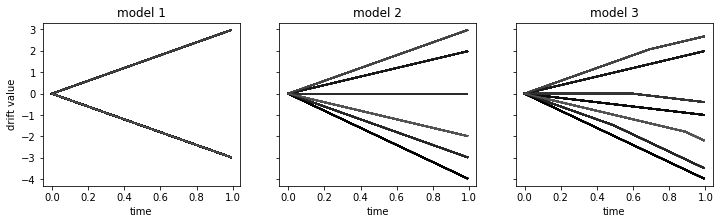

In [16]:
# Simulate Drift

# define fixed params
X0 = 0 # start value of the drift process
dt = 0.01 # integration time step
dur = 1 # time for which we run the simulation
T = np.arange(0, dur, dt) # time vector for the simulation

# define variable params:
sigma = 0.0 # variance
drift_weight = 10.0
threshold_drift = 0.15
drift_rate = 3.0
threshold_go = 1
nd_time = 0.2

# initialize plot
fig, ax = plt.subplots(1,3, figsize = (12,3), sharex = True, sharey = True)
trial_n = len(np.unique(df['trial']))

for n in np.arange(50):

    # set up data frames
    m1_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
    m2_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
    m3_drift = pd.DataFrame(np.zeros((trial_n,len(T))))

    m1_rt = pd.Series(np.zeros(trial_n))
    m2_rt = pd.Series(np.zeros(trial_n))
    m3_rt = pd.Series(np.zeros(trial_n))

    m1_resp = pd.Series(np.zeros(trial_n))
    m2_resp = pd.Series(np.zeros(trial_n))
    m3_resp = pd.Series(np.zeros(trial_n))

    ## Start simulation

    color = iter(plt.cm.Greys_r(np.linspace(0,1,25)))
    print(len(df))
    for idx, trial in enumerate(np.unique(df['trial'])):
        # get data from current trial only
        trial_data = long_format(df, trial)
        trial_data.reset_index(drop=True, inplace = True)

        # set parameters for drift
        trial_params = {
        'sigma': sigma,
        'trial': trial_data,
        'drift_weight': drift_weight,
        'threshold_drift': threshold_drift,
        'drift_rate': drift_rate,   
        'threshold_go': threshold_go,
        'nd_time': nd_time
        }

        # run drift diffusion    
        simulation_m1, rt_m1,res_m1 = timed_integrator(get_params_model1, model1, stoch_var, X0, T, dt, **trial_params)
        simulation_m2, rt_m2,res_m2 = timed_integrator(get_params_model2, model2, stoch_var, X0, T, dt, **trial_params)
        simulation_m3, rt_m3,res_m3 = timed_integrator(get_params_model3, model3, stoch_var, X0, T, dt, **trial_params)

        # write drift result to table
        m1_drift.iloc[idx,:] = simulation_m1.T[0]
        m1_rt.iloc[idx] = rt_m1
        m1_resp.iloc[idx] = res_m1

        m2_drift.iloc[idx,:] = simulation_m2.T[0]
        m2_rt.iloc[idx] = rt_m2
        m2_resp.iloc[idx] = res_m2

        m3_drift.iloc[idx,:] = simulation_m3.T[0]
        m3_rt.iloc[idx] = rt_m3
        m3_resp.iloc[idx] = res_m3


        # plot if needed    
        if trial % 111 == 0:
            c = next(color)
            ax[0].plot(T, simulation_m1, color = c)
            ax[0].set_title('model 1')
            ax[0].set_xlabel('time')
            ax[0].set_ylabel('drift value')
            ax[1].plot(T, simulation_m2, color = c)
            ax[1].set_title('model 2')
            ax[1].set_xlabel('time')
            ax[2].plot(T, simulation_m3, color = c)
            ax[2].set_title('model 3')
            ax[2].set_xlabel('time')
        
    try:
        print(n)
        print(len(m1_drift))
        NS2_drift_m1 = pd.concat([NS2_drift_m1, m1_drift], axis = 0)
        NS2_rt_m1 = pd.concat([NS2_rt_m1, m1_rt], axis = 0)
        NS2_resp_m1 = pd.concat([NS2_resp_m1, m1_resp], axis = 0)
        
        NS2_drift_m2 = pd.concat([NS2_drift_m2, m2_drift], axis = 0)
        NS2_rt_m2 = pd.concat([NS2_rt_m2, m2_rt], axis = 0)
        NS2_resp_m2 = pd.concat([NS2_resp_m2, m2_resp], axis = 0)
        
        NS2_drift_m3 = pd.concat([NS2_drift_m3, m3_drift], axis = 0)
        NS2_rt_m3 = pd.concat([NS2_rt_m3, m3_rt], axis = 0)
        NS2_resp_m3 = pd.concat([NS2_resp_m3, m3_resp], axis = 0)
    
    except:
        
        NS2_drift_m1 = m1_drift
        NS2_rt_m1 = m1_rt
        NS2_resp_m1 = m1_resp
        
        NS2_drift_m2 = m2_drift
        NS2_rt_m2 = m2_rt
        NS2_resp_m2 = m2_resp
        
        NS2_drift_m3 = m3_drift
        NS2_rt_m3 = m3_rt
        NS2_resp_m3 = m3_resp
        
#plt.savefig(path_figs + 'timed_ddm_models_NoiseStrike2.png')   



In [ ]:
model_fig, model_ax = plt.subplots(1,3, figsize = [13, 3], sharex = True, sharey = True)
color = iter(plt.cm.Greys(np.linspace(0,1,8))[2:])

for t,c in zip([3, 136,533, 710, 110, 113],color):
    
    model_ax[0].plot(T, m1_drift.loc[t,:], color = c)
    model_ax[0].set_title('model 1')
    model_ax[0].set_xlabel('time')
    model_ax[0].set_ylabel('drift value')
    model_ax[1].plot(T, m2_drift.loc[t,:], color = c)
    model_ax[1].set_title('model 2')
    model_ax[1].set_xlabel('time')
    model_ax[1].set_ylabel('drift value')
    model_ax[2].plot(T, m3_drift.loc[t,:], color = c)
    model_ax[2].set_title('model 2')
    model_ax[2].set_xlabel('time')
    model_ax[2].set_ylabel('drift value')
    
plt.savefig(path_figs + 'timed_ddm_models_NoiseStrike2.png') 

In [ ]:
plt.plot(m3_drift.loc[113,:])

In [17]:
dat_rsp_m1 = pd.concat([df,m1_resp], axis = 1)
dat_rsp_m2 = pd.concat([df,m2_resp], axis = 1)
dat_rsp_m3 = pd.concat([df,m3_resp], axis = 1)

In [18]:
dat_rsp_m1.to_csv('dat_rsp_m1_noise0.csv')
dat_rsp_m2.to_csv('dat_rsp_m2_noise0.csv')
dat_rsp_m3.to_csv('dat_rsp_m3_noise0.csv')

In [ ]:
NS2_drift_m1.reset_index(drop=True, inplace = True)
NS2_rt_m1.reset_index(drop=True, inplace = True)
NS2_resp_m1.reset_index(drop=True, inplace = True)
        
NS2_drift_m2.reset_index(drop=True, inplace = True)
NS2_rt_m2.reset_index(drop=True, inplace = True)
NS2_resp_m2.reset_index(drop=True, inplace = True)
        
NS2_drift_m3.reset_index(drop=True, inplace = True)
NS2_rt_m3.reset_index(drop=True, inplace = True)
NS2_resp_m3.reset_index(drop=True, inplace = True)

In [ ]:
fi, ax = plt.subplots(1)
for d in [378, 387, 388, 396, 397, 398]:
    ax.plot(NS2_drift_m3.loc[d,:]);

In [ ]:
m1_drift.to_csv('m1_drift.csv', sep=',')
m2_drift.to_csv('m2_drift.csv', sep=',')
m3_drift.to_csv('m3_drift.csv', sep=',')

m1_rt.to_csv('m1_rt.csv', sep =',') 
m2_rt.to_csv('m2_rt.csv', sep =',') 
m3_rt.to_csv('m3_rt.csv', sep =',') 

m1_resp.to_csv('m1_resp.csv', sep =',') 
m2_resp.to_csv('m2_resp.csv', sep =',') 
m3_resp.to_csv('m3_resp.csv', sep =',') 

In [ ]:
# instead of simulating new data, we load the data we've simulated last time
m1_drift = pd.read_csv('m1_drift.csv')
m2_drift = pd.read_csv('m2_drift.csv')
m3_drift = pd.read_csv('m3_drift.csv')

m1_rt = pd.read_csv('m1_rt.csv')
m2_rt = pd.read_csv('m2_rt.csv')
m3_rt = pd.read_csv('m3_rt.csv')

m1_resp = pd.read_csv('m1_resp.csv')
m2_resp = pd.read_csv('m2_resp.csv')
m3_resp = pd.read_csv('m3_resp.csv')



In [ ]:
hist_plot, hist_axs = plt.subplots(1,3, figsize = (15,3), sharex=False, sharey=False)

hist_axs[0].hist(m1_rt);
hist_axs[1].hist(m2_rt[m2_rt<1]);
hist_axs[2].hist(m3_rt[m3_rt<1]);

print(mse(m2_rt[m3_rt<1],m3_rt[m3_rt<1]))

In [ ]:
# the mean drift of each model in each tp
m1_mean = np.mean(abs(m1_drift),axis = 0)
m2_mean = np.mean(abs(m2_drift),axis = 0)
m3_mean = np.mean(abs(m3_drift),axis = 0)

fig2,ax2 = plt.subplots(1,1);

ax2.plot(T,m1_mean, label = 'm1')
ax2.plot(T,m2_mean, label = 'm2')
ax2.plot(T,m3_mean, label = 'm3')
ax2.legend()
ax2.set_xlabel('time in s')
ax2.set_ylabel('means absolute drift value');

A reminder, these are the values we set to generate the decisions above:
    

    sigma = 1 
    drift_weight = 4.0
    threshold_drift = 0.3
    drift_rate = 1.5
    threshold_go = 0.5
        
Let's try if we can fit these paramters :)

In [ ]:
# mean squared errors function
def mse(modelled_data, measured_data):
    """
    returns the mean squared error between two data sets. Important: both datasets need to have the same length
    """
    mse = np.mean((modelled_data-measured_data)**2)
    return mse

# build an objective function

def objective_m1(params, X0 = 0, dt = dt, threshold_go = threshold_go, df = df):
    
    """
    The objective we are trying to minimize later - takes the paramters we are using to fit the function
    fits the function as refined and
    returns a metric to evaluate the function fit to the data (mse in this case)
    this objective function is fed into the optimizer function.
    
    Some variables need to be defined before executing this function:
    data_go = the experimental setup and information for every trial (with or without no_gos).
    drift_slice = the indices to trials with "go" responses (= trial numbers)
    m1_drift_go = the measured data - same length as data_slice
    """
    
    # unpack params
    drift_rate = params[0]
    tim_drift = params[1]
        
    # constant params
    data = df.reset_index(drop = True)
    sigma = 1
    
    range_max = np.round(m1_rt.max(),1)
    bin_width = 0.1
    num_bins = int(np.round(range_max/bin_width))
    
    go_m1_rt = m1_rt[m1_resp == 'go']
    bins_obs = np.histogram(go_m1_rt, bins=num_bins, range=(0, range_max), density=False)[0]
    bins_obs = np.hstack([bins_obs, len(m1_resp[m1_resp == 'nogo'])])
    
    dur = max(data['time']) # time for which we run the simulation
    T = np.arange(0, dur, dt) # time vector for the simulation
    
    # init data frames
    sim_drift = pd.DataFrame(np.zeros((len(np.unique(data['trial'])),len(T))))
    sim_rt = pd.Series(np.zeros(len(np.unique(data['trial']))))
    sim_resp = pd.Series(np.zeros(len(np.unique(data['trial']))))    
            
    # get reaction for every trial
    for idx, trial in enumerate(np.unique(data['trial'])): 
        # find the experimental setup for the given trial
        trial_data = data[data['trial'] == trial] 
        trial_data.reset_index(drop=True, inplace = True)
        
        # parameters for drift
        trial_params = {
        'sigma': sigma,
        'drift_rate': drift_rate,
        'tim_drift': tim_drift,
        'trial': trial_data,
        'threshold_go': threshold_go,
        'nd_time' : 0
        }
        
        model1_drift, tim , rt, resp = timed_integrator(get_params_model1, model1, stoch_var, X0, T, dt, **trial_params)

        # write out information in data frame
        sim_drift.iloc[idx,0:len(model1_drift)] = model1_drift.T[0]
        sim_rt.iloc[idx] = rt
        sim_resp.iloc[idx] = resp
                                             
    try:
        #compute mse
        # output = mse(sim_rt, x)
        
        # compute chi squared
        go_sim_rt = sim_rt[sim_resp=='go']
        bins_est = np.histogram(go_sim_rt, bins=num_bins, range=(0, range_max), density=False)[0]
        bins_est = np.hstack([bins_est, len(sim_resp[sim_resp == 'nogo'])])
        
        if np.any(bins_est == 0):
            print('zero division detected, needed to correct')
            bins_est[bins_est == 0] = 1
        
        output, p = scipy.stats.chisquare(bins_obs, bins_est)
        
    except Exception as e:
        # if something goes wrong, let us know a few things:
        print(sim_rt)
        print(x)
        print('the drift rate was: {}'.format(drift_rate))
        print('sigma was: {}'.format(sigma))
        
        raise e
    if np.isnan(output) or (not np.isfinite(output)):
        print('nan detected')
    print('objective evaluated at drift_rate: {}, time_drift: {}'.format(drift_rate, tim_drift))
    print('the discovered p_value was: {}'.format(p))
    return output

In [ ]:
# define the parameter space where we want to look
space = [(0.0,2.0),#drift rate
        (0.5, 1.5)] # tim_drift

# run the optimizer
try:
    r = gp_minimize(objective_m1,space,n_calls=20,random_state=1);   
except ValueError as e:
    print(r)
    raise e

In [ ]:
print(r.x)
print(r.fun)
skopt.plots.plot_objective(r)

In [ ]:
# build an objective function

def objective_m2(params, X0 = 0, dt = dt, threshold_go = threshold_go, df = df):
    
    """
    The objective we are trying to minimize later - takes the paramters we are using to fit the function
    fits the function as refined and
    returns a metric to evaluate the function fit to the data (mse in this case)
    this objective function is fed into the optimizer function.
    
    Some variables need to be defined before executing this function:
    data_go = the experimental setup and information for every trial (with or without no_gos).
    drift_slice = the indices to trials with "go" responses (= trial numbers)
    m2_drift_go = the measured data - same length as data_slice
    """
    
    # unpack params
    drift_weight = params[0]
    threshold_drift = params[1]
    time_drift = params[2]
    
    
    # constant params
    data = df.reset_index(drop=True) # data_go needs to be defined in the workspace before executing this function
    #x = m2_rt.reset_index(drop=True) #m1_drift_go needs to be defined before executing
    sigma = 1
    
    range_max = np.round(m2_rt.max(),1)
    bin_width = 0.1
    num_bins = int(np.round(range_max/bin_width))
    
    go_m2_rt = m2_rt[m2_resp == 'go']
    bins_obs = np.histogram(go_m2_rt, bins=num_bins, range=(0, range_max), density=False)[0]
    bins_obs = np.hstack([bins_obs, len(m2_resp[m2_resp == 'nogo'])])
    
    dur = max(data['time']) # time for which we run the simulation
    T = np.arange(0, dur, dt) # time vector for the simulation
    
    # init data frames
    sim_drift = pd.DataFrame(np.zeros((len(np.unique(data['trial'])),len(T))))
    sim_rt  = pd.Series(np.zeros(len(np.unique(data['trial']))))
    sim_resp = pd.Series(np.zeros(len(np.unique(data['trial']))))
     
    # get reaction for every trial
    for idx, trial in enumerate(np.unique(data['trial'])): 
        # find the experimental setup for the given trial
        trial_data = data[data['trial'] == trial] 
        trial_data.reset_index(drop=True, inplace = True)

        # parameters for drift
        trial_params = {
        'sigma': sigma,
        'drift_weight': drift_weight,
        'threshold_drift': threshold_drift,
        'trial': trial_data,
        'tim_drift': time_drift,
        'threshold_go': threshold_go,
        'nd_time': 0
        }
        
        model2_drift, tim, rt, resp = timed_integrator(get_params_model2, model2, stoch_var, X0, T, dt, **trial_params)
        #if resp != "go":
        #    # penalize wrong no_go decisions of cases when the decision boundary was not reached
        #    rt = 9999
        # write out information in data frame
        sim_drift.iloc[idx,:] = model2_drift.T[0]
        sim_rt.iloc[idx] = rt
        sim_resp.iloc[idx] = resp
                                             
    try:
        #compute mse
        #output = mse(sim_rt, x)
        #compute chi squared
        
        go_sim_rt = sim_rt[sim_resp=='go']
        bins_est = np.histogram(go_sim_rt, bins=num_bins, range=(0, range_max), density=False)[0]
        bins_est = np.hstack([bins_est, len(sim_resp[sim_resp == 'nogo'])])
        
        if np.any(bins_est == 0):
            print('zero division detected, needed to correct')
            bins_est[bins_est == 0] = 1
        
        output, p = scipy.stats.chisquare(bins_obs, bins_est)
        
    except Exception as e:
        # if something goes wrong, let us know a few things:
        print(sim_rt)
        print(x)
        print('the drift rate was: {}'.format(drift_rate))
        print('sigma was: {}'.format(sigma))
        
        raise e
        
    print('objective evaluated at drift_weight: {},threshold_drift: {}, time_drift: {}'.format(drift_weight, threshold_drift, time_drift))
    print('the discovered p_value was: {}'.format(p))
    return output

In [ ]:
# define the parameter space where we want to look
space2 = [(1.0,5.0),#drift weight
          (0, 0.5), #threshold drift
          (0.0, 2.0)] # time drift

# run the optimizer
r2 = gp_minimize(objective_m2,space2,n_calls=20,random_state=1); 

In [ ]:
print(r2.x)
skopt.plots.plot_objective(r2)

In [ ]:
# build an objective function

def objective_m3(params,X0 = 0, dt = dt, threshold_go = threshold_go, df = df):
    
    """
    The objective we are trying to minimize later - takes the paramters we are using to fit the function
    fits the function as refined and
    returns a metric to evaluate the function fit to the data (mse in this case)
    this objective function is fed into the optimizer function.
    
    Some variables need to be defined before executing this function:
    data_go = the experimental setup and information for every trial (with or without no_gos).
    drift_slice = the indices to trials with "go" responses (= trial numbers)
    m3_drift_go = the measured data - same length as data_slice
    """
    
    # unpack params
    drift_weight = params[0]
    time_drift = params [1]
    
    # constant params
    data = df.reset_index(drop=True) # data_go needs to be defined in the workspace before executing this function
    sigma = 1
    
    range_max = np.round(m3_rt.max(),1)
    bin_width = 0.1
    num_bins = int(np.round(range_max/bin_width))
    
    go_m3_rt = m3_rt[m3_resp == 'go']
    bins_obs = np.histogram(go_m3_rt, bins=num_bins, range=(0, range_max), density=False)[0]
    bins_obs = np.hstack([bins_obs, len(m3_resp[m3_resp == 'nogo'])])
    
    #x = m3_drift_go.reset_index(drop=True) #m1_drift_go needs to be defined before executing

    dur = max(data['time']) # time for which we run the simulation
    T = np.arange(0, dur, dt) # time vector for the simulation
    
    # init data frames
    sim_drift = pd.DataFrame(np.zeros((len(np.unique(data['trial'])),len(T))))
    sim_rt  = pd.Series(np.zeros(len(np.unique(data['trial']))))
    sim_resp = pd.Series(np.zeros(len(np.unique(data['trial']))))
     
    # get reaction for every trial
    for idx, trial in enumerate(np.unique(data['trial'])): 
        # find the experimental setup for the given trial
        trial_data = data[data['trial'] == trial] 
        trial_data.reset_index(drop=True, inplace = True)

        # parameters for drift
        trial_params = {
        'sigma': sigma,
        'drift_weight': drift_weight,
        'tim_drift': time_drift,
        'trial': trial_data,
        'threshold_go': threshold_go,
        'nd_time': 0
        }
        
        model3_drift, tim, rt, resp = timed_integrator(get_params_model3, model3, stoch_var, X0, T, dt, **trial_params)
        #if resp != "go":
            # penalize wrong no_go decisions of cases when the decision boundary was not reached
        #    rt = 9999
        # write out information in data frame
        sim_drift.iloc[idx,0:len(model3_drift)] = model3_drift.T[0]
        sim_rt[idx] = rt
        sim_resp[idx] = resp
                                             
    try:
        # compute mse
        # output = mse(sim_rt, x)
        # compute chi squared
        go_sim_rt = sim_rt[sim_resp=='go']
        bins_est = np.histogram(go_sim_rt, bins=num_bins, range=(0, range_max), density=False)[0]
        bins_est = np.hstack([bins_est, len(sim_resp[sim_resp == 'nogo'])])
        
        if np.any(bins_est == 0):
            print('zero division detected, needed to correct')
            bins_est[bins_est == 0] = 1
        
        output, p = scipy.stats.chisquare(bins_obs, bins_est)
        
    except Exception as e:
        # if something goes wrong, let us know a few things:
        print(sim_rt)
        print(x)
        print('the drift rate was: {}'.format(drift_rate))
        print('sigma was: {}'.format(sigma))
        
        raise e
    
    print('objective evaluated at drift_weight: {}, time_drift: {}'.format(drift_weight, time_drift))
    print('the discovered p_value was: {}'.format(p))
    return output

In [ ]:
# define the parameter space where we want to look
space3 = [(1.0,5.0),#drift weight
         (0.0,2.0)]# time drift

# run the optimizer
r3 = gp_minimize(objective_m3,space3,n_calls=20,random_state=1); 

In [ ]:
print(r3.x)
skopt.plots.plot_objective(r3)

In [ ]:
# compare the models to the simulation visually

model_comp, mc_axs = plt.subplots(1,3, figsize = [15,5])

est_m1_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
est_m2_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
est_m3_drift = pd.DataFrame(np.zeros((trial_n,len(T))))

est_m1_rt = pd.Series(np.zeros(trial_n))
est_m2_rt = pd.Series(np.zeros(trial_n))
est_m3_rt = pd.Series(np.zeros(trial_n))

est_m1_resp = pd.Series(np.zeros(trial_n))
est_m2_resp = pd.Series(np.zeros(trial_n))
est_m3_resp = pd.Series(np.zeros(trial_n))

for idx, trial in enumerate(np.unique(df['trial'])):
    
    # get data from current trial only
    trial_data = df[df['trial'] == trial] 
    trial_data.reset_index(drop=True, inplace = True)
    #print(trial_data.loc[0])
    # set parameters for drift
    
    trial_params1 = {
        'sigma': 1,
        'trial': trial_data,
        'drift_weight': 4,
        'threshold_drift': 0.3,
        'drift_rate': r.x[0],
        'tim_drift': r.x[1],    
        'threshold_go': 0.5,
        'nd_time': 0 
        }
    
    trial_params2= {
        'sigma': 1,
        'trial': trial_data,
        'drift_weight': r2.x[0],
        'threshold_drift': r2.x[1],
        'drift_rate': 1.5,
        'tim_drift': r2.x[2],    
        'threshold_go': 0.5,
        'nd_time': 0 
        }
    
    trial_params3= {
        'sigma': 1,
        'trial': trial_data,
        'drift_weight': r3.x[0],
        'threshold_drift': 0.3,
        'drift_rate': 1.5,
        'tim_drift': r2.x[1],    
        'threshold_go': 0.5,
        'nd_time': 0 
        }
    
    # run drift diffusion    
    est_m1, est_time_m1, est_rt_m1,est_res_m1 = timed_integrator(get_params_model1, model1, stoch_var, X0, T, dt, **trial_params1)
    est_m2, est_time_m2, est_rt_m2,est_res_m2 = timed_integrator(get_params_model2, model2, stoch_var, X0, T, dt, **trial_params2)
    est_m3, est_time_m3, est_rt_m3,est_res_m3 = timed_integrator(get_params_model3, model3, stoch_var, X0, T, dt, **trial_params3)
    
    # write drift result to table
    est_m1_drift.iloc[idx,:] = est_m1.T[0]
    est_m1_rt.iloc[idx] = est_rt_m1
    est_m1_resp.iloc[idx] = est_res_m1

    est_m2_drift.iloc[idx,:] = est_m2.T[0]
    est_m2_rt.iloc[idx] = est_rt_m2
    est_m2_resp.iloc[idx] = est_res_m2

    est_m3_drift.iloc[idx,:] = est_m3.T[0]
    est_m3_rt.iloc[idx] = est_rt_m3
    est_m3_resp.iloc[idx] = est_res_m3
    
t = 0.1 
bins_sim = math.ceil((0.7 - 0.0)/t)
bins_est = math.ceil((0.7-0.0)/t)

mc_axs[0].hist(est_m1_rt[est_m1_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est)
mc_axs[0].hist(m1_rt[m1_resp == 'go'], alpha = 0.5, label = 'simulated', bins = bins_sim)

mc_axs[1].hist(est_m2_rt[est_m2_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est)
mc_axs[1].hist(m2_rt[m2_resp == 'go'], alpha = 0.5, label = 'simulated', bins = bins_sim)

mc_axs[2].hist(est_m3_rt[est_m3_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est, range= [0,0.7])
mc_axs[2].hist(m3_rt[m3_resp == 'go'], alpha = 0.5, label = 'simulated', bins = bins_sim, range= [0,0.7]);

In [ ]:
# fit the 3 models to the observed response times

# step1 : reshape the full data set to make it usable for the model
exp_des = pd.read_csv('../2_cleaned/df_cleaned_rc_6.csv')

In [ ]:
def long_format(data, index):
    time = data.loc[index, ['tt_1','tt_2','tt_3','tt_4','tt_5','tt_6']]
    time_norm = (time - time[0])/1000
    
    trial = data.loc[index,'trial']
    subject = data.loc[index,'subject']
    
    p_in = data.loc[index, ['pi_pos01', 'pi_pos02', 'pi_pos03', 'pi_pos04', 'pi_pos05', 'pi_pos06']]
    
    out_df = pd.concat([time_norm.reset_index(drop = True), p_in.reset_index(drop = True)], axis = 1)
    out_df.columns = ['time', 'p_in']
    
    return(out_df)
    
long_format(exp_des,1)

In [ ]:
# start by fitting one subject:

sub_dat = exp_des[exp_des.subject == 'AE'].reset_index(drop = True)
true_rt = sub_dat.rea_time
true_resp = sub_dat.goResp

In [ ]:
def gen_objective(params, X0 = 0, dt = 0.001, threshold_go = 1, df = None, m_func = None, par_func = None, model = None, rts = None, resps = None):
    
    """
    The objective we are trying to minimize later - takes the paramters we are using to fit the function
    fits the function as refined and
    returns a metric to evaluate the function fit to the data (mse in this case)
    this objective function is fed into the optimizer function.
    
    Some variables need to be defined before executing this function:
    data_go = the experimental setup and information for every trial (with or without no_gos).
    drift_slice = the indices to trials with "go" responses (= trial numbers)
    m1_drift_go = the measured data - same length as data_slice
    """
    if model == 1:
        # unpack params
        drift_rate = params[0]
        tim_drift = params[1]
        nd_time = params[2]
    
    elif model == 2: 
        # unpack params
        drift_weight = params[0]
        threshold_drift = params[1]
        time_drift = params[2]
        nd_time = params[3]
        
    elif model == 3:
        # unpack params
        drift_weight = params[0]
        time_drift = params [1]
        nd_time = params[2]
        
    # constant params
    data = df.reset_index(drop = True)
    sigma = 0
    
    range_max = np.round(rts.max(),1)
    bin_width = 0.1
    num_bins = int(np.round(range_max/bin_width))
    
    go_rt = rts[resps == 1]
    bins_obs = np.histogram(go_rt, bins=num_bins, range=(0, range_max), density=False)[0]
    bins_obs = np.hstack([bins_obs, len(resps[resps == 0])])
    
    dur = 1 # time for which we run the simulation
    T = np.arange(0, dur, dt) # time vector for the simulation
    
    # init data frames
    sim_drift = pd.DataFrame(np.zeros((len(data),len(T))))
    sim_time = pd.DataFrame(np.zeros((len(data),len(T))))
    sim_rt = pd.Series(np.zeros(len(data)))
    sim_resp = pd.Series(np.zeros(len(data)))    
            
    # get reaction for every trial
    for idx, trial in enumerate(data.index): 
        
        # find the experimental setup for the given trial
        trial_data = long_format(data, trial) 
        trial_data.reset_index(drop=True, inplace = True)
        
        # parameters for drift
        if model  == 1:
            trial_params = {
            'sigma': sigma,
            'drift_rate': drift_rate,
            'tim_drift': tim_drift,
            'trial': trial_data,
            'threshold_go': threshold_go,
            'nd_time' :  nd_time
            }
            
        elif model == 2:
            trial_params= {
            'sigma': sigma,
            'trial': trial_data,
            'drift_weight': drift_weight,
            'threshold_drift': threshold_drift,
            'drift_rate': None,
            'tim_drift': time_drift,    
            'threshold_go': threshold_go,
            'nd_time': nd_time
            }
            
        elif model == 3:
            trial_params = {
                'sigma': sigma,
                'trial': trial_data,
                'drift_weight': drift_weight,
                'threshold_drift': None,
                'drift_rate': None,
                'tim_drift': time_drift,    
                'threshold_go': threshold_go,
                'nd_time': nd_time 
                }
            
        model_drift, time , rt, resp = timed_integrator(par_func, m_func, stoch_var, X0, T, dt, **trial_params)

        # write out information in data frame
        sim_drift.iloc[idx,0:len(model_drift)] = model_drift.T[0]
        sim_time.iloc[idx,0:len(time)] = time.T[0]
        sim_rt.iloc[idx] = rt
        sim_resp.iloc[idx] = resp
                                             
    try:
        
        # compute chi squared
        go_sim_rt = sim_rt[sim_resp=='go']
        bins_est = np.histogram(go_sim_rt, bins=num_bins, range=(0, range_max), density=False)[0]
        bins_est = np.hstack([bins_est, len(sim_resp[sim_resp == 'nogo'])])
        
        if np.any(bins_est == 0):
            print('zero division detected, needed to correct')
            bins_est[bins_est == 0] = 1
        
        output, p = scipy.stats.chisquare(bins_obs, bins_est)
        
    except Exception as e:
        # if something goes wrong, let us know a few things:
        print(sim_rt)
        print(x)
        print('the drift rate was: {}'.format(drift_rate))
        print('sigma was: {}'.format(sigma))
        
        raise e
    if np.isnan(output) or (not np.isfinite(output)):
        print('nan detected')
    #print('objective evaluated at the following values {}'.format(trial_params))
    #print('the discovered p_value was: {}'.format(p))
    return output

In [ ]:
obj_sub_m1 = functools.partial(gen_objective, df = sub_dat, m_func = model1, par_func = get_params_model1, model = 1, rts = true_rt, resps = true_resp)
obj_sub_m2 = functools.partial(gen_objective, df = sub_dat, m_func = model2, par_func = get_params_model2, model = 2, rts = true_rt, resps = true_resp)
obj_sub_m3 = functools.partial(gen_objective, df = sub_dat, m_func = model3, par_func = get_params_model3, model = 3, rts = true_rt, resps = true_resp)


In [ ]:
# define the parameter space where we want to look
params_m1 = []

for sub in np.unique(exp_des.subject):
    
    print('estimating subject {}'.format(sub))
    sub_dat = exp_des[exp_des.subject == sub].reset_index(drop = True)
    true_rt = sub_dat.rea_time
    true_resp = sub_dat.goResp
    
    obj_sub_m1 = functools.partial(gen_objective, df = sub_dat, m_func = model1, par_func = get_params_model1, model = 1, rts = true_rt, resps = true_resp)

    space_m1 = [(0.0, 2.0),#drift rate
            (0.0, 2.0), # tim_drift
            (0.0, 1.0)] # non decision time

    # run the optimizer
    try:
        r1 = gp_minimize(obj_sub_m1,space_m1,n_calls=20,random_state=1);   
    except ValueError as e:
        print(r1)
        raise e
        
    params_m1.append(r1.x)

In [ ]:
params_m1

In [ ]:
print(r1.x)
skopt.plots.plot_objective(r1)

In [ ]:
params_m2 = []

for sub in np.unique(exp_des.subject):
    
    print('estimating subject {}'.format(sub))
    sub_dat = exp_des[exp_des.subject == sub].reset_index(drop = True)
    true_rt = sub_dat.rea_time
    true_resp = sub_dat.goResp
    
    obj_sub_m2 = functools.partial(gen_objective, df = sub_dat, m_func = model2, par_func = get_params_model2, model = 2, rts = true_rt, resps = true_resp)

    space_m2 = [(0.0,10.0),#drift weight
              (0.0, 1.0), #threshold drift
              (0.0, 2.0), # time drift
              (0.0, 1.0)] # non decision time

    # run the optimizer
    try:
        r2 = gp_minimize(obj_sub_m2,space_m2,n_calls=20,random_state=1);   
    except ValueError as e:
        print(r2)
        raise e
        
    params_m2.append(r2.x)

In [ ]:
print(r2.x)
skopt.plots.plot_objective(r2)

In [ ]:
# define the parameter space where we want to look
params_m3 = []

for sub in np.unique(exp_des.subject):
    
    print('estimating subject {}'.format(sub))
    sub_dat = exp_des[exp_des.subject == sub].reset_index(drop = True)
    true_rt = sub_dat.rea_time
    true_resp = sub_dat.goResp
    
    obj_sub_m3 = functools.partial(gen_objective, df = sub_dat, m_func = model3, par_func = get_params_model3, model = 3, rts = true_rt, resps = true_resp)
    
    space_m3 = [(0.0,5.0),# drift weight
             (0.0,2.0), # time drift
             (0.0, 1.0)]# non-decision time

    # run the optimizer
    try:
        r3 = gp_minimize(obj_sub_m3,space_m3,n_calls=20,random_state=1);   
    except ValueError as e:
        print(r3)
        raise e
    
    params_m3.append(r3.x)

In [ ]:
print(r3.x)
skopt.plots.plot_objective(r3)

In [ ]:
pm1 = pd.DataFrame(params_m1, columns = ['drift_rate', 'time_drift', 'nd_time'], index = np.unique(exp_des.subject))
pm2 = pd.DataFrame(params_m2, columns = ['drift_weight', 'threshold_drift', 'time_drift', 'nd_time'], index = np.unique(exp_des.subject))
pm3 = pd.DataFrame(params_m3, columns = ['drift_weight', 'time_drift', 'nd_time'], index = np.unique(exp_des.subject))

pm1.to_csv('params_m1.csv')
pm2.to_csv('params_m2.csv')
pm3.to_csv('params_m3.csv')

In [ ]:
# compare the models to the simulation visually

#sub_fit, sf_axs = plt.subplots(1,3, figsize = [15,5])
full_init = False

for sub in np.unique(exp_des.subject):
    
    print('loading subject {}'.format(sub))
    sub_dat = exp_des[exp_des.subject == sub].reset_index(drop = True)
    
    trial_n = len(sub_dat)

    est_m1_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
    est_m2_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
    est_m3_drift = pd.DataFrame(np.zeros((trial_n,len(T))))

    est_m1_rt = pd.Series(np.zeros(trial_n))
    est_m2_rt = pd.Series(np.zeros(trial_n))
    est_m3_rt = pd.Series(np.zeros(trial_n))

    est_m1_resp = pd.Series(np.zeros(trial_n))
    est_m2_resp = pd.Series(np.zeros(trial_n))
    est_m3_resp = pd.Series(np.zeros(trial_n))

    for idx, trial in enumerate(np.unique(sub_dat.index)):

        # get data from current trial only
        trial_data = long_format(sub_dat, trial) 
        trial_data.reset_index(drop=True, inplace = True)
        #print(trial_data.loc[0])
        # set parameters for drift

        trial_params1 = {
            'sigma': 1,
            'trial': trial_data,
            'drift_weight': None,
            'threshold_drift': None,
            'drift_rate': pm1.loc[sub,'drift_rate'],
            'tim_drift': pm1.loc[sub,'time_drift'],    
            'threshold_go': 1,
            'nd_time': pm1.loc[sub, 'nd_time'] 
            }

        trial_params2= {
            'sigma': 1,
            'trial': trial_data,
            'drift_weight': pm2.loc[sub, 'drift_weight'],
            'threshold_drift': pm2.loc[sub, 'threshold_drift'],
            'drift_rate': None,
            'tim_drift': pm2.loc[sub,'time_drift'],    
            'threshold_go': 1,
            'nd_time': pm2.loc[sub, 'nd_time']
            }

        trial_params3= {
            'sigma': 1,
            'trial': trial_data,
            'drift_weight': pm3.loc[sub,'drift_weight'],
            'threshold_drift': None,
            'drift_rate': None,
            'tim_drift': pm3.loc[sub,'time_drift'],    
            'threshold_go': 1,
            'nd_time': pm3.loc[sub,'nd_time'] 
            }

        # run drift diffusion    
        est_m1, est_time_m1, est_rt_m1,est_res_m1 = timed_integrator(get_params_model1, model1, stoch_var, X0, T, dt, **trial_params1)
        est_m2, est_time_m2, est_rt_m2,est_res_m2 = timed_integrator(get_params_model2, model2, stoch_var, X0, T, dt, **trial_params2)
        est_m3, est_time_m3, est_rt_m3,est_res_m3 = timed_integrator(get_params_model3, model3, stoch_var, X0, T, dt, **trial_params3)

        # write drift result to table
        est_m1_drift.iloc[idx,:] = est_m1.T[0]
        est_m1_rt.iloc[idx] = est_rt_m1
        est_m1_resp.iloc[idx] = est_res_m1

        est_m2_drift.iloc[idx,:] = est_m2.T[0]
        est_m2_rt.iloc[idx] = est_rt_m2
        est_m2_resp.iloc[idx] = est_res_m2

        est_m3_drift.iloc[idx,:] = est_m3.T[0]
        est_m3_rt.iloc[idx] = est_rt_m3
        est_m3_resp.iloc[idx] = est_res_m3

    
    simulated_answer = pd.concat([est_m1_rt, est_m1_resp, est_m2_rt, est_m2_resp, est_m3_rt, est_m3_resp], axis = 1)
    simulated_answer.columns = ['m1_rt', 'm1_resp', 'm2_rt', 'm2_resp','m3_rt', 'm3_resp']
    simulated_answer = pd.concat([sub_dat, simulated_answer], axis =1)
    est_m1_drift['subject'] = sub
    est_m2_drift['subject'] = sub
    est_m3_drift['subject'] = sub
    
    if not full_init:
        
        full_sim = simulated_answer
        full_m1_drift = est_m1_drift
        full_m2_drift = est_m2_drift
        full_m3_drift = est_m3_drift
        
        full_init = True
        
    else:
        
        full_sim = pd.concat([full_sim, simulated_answer], axis = 0)
        full_m1_drift = pd.concat([full_m1_drift, est_m1_drift], axis = 0)
        full_m2_drift = pd.concat([full_m2_drift, est_m2_drift], axis = 0) 
        full_m3_drift = pd.concat([full_m3_drift, est_m3_drift], axis = 0)
        
    

In [ ]:
full_sim.to_csv('all_resp_simulated.csv')
full_m1_drift.to_csv('all_m1_drift_simulated.csv')
full_m2_drift.to_csv('all_m2_drift_simulated.csv')
full_m3_drift.to_csv('all_m3_drift_simulated.csv')

In [ ]:
full_sim.reset_index(drop=True, inplace = True)
full_m1_drift.reset_index(drop=True, inplace = True)
full_m2_drift.reset_index(drop=True, inplace = True)
full_m3_drift.reset_index(drop=True, inplace = True)

In [ ]:
t = 0.1 
bins_sim = math.ceil((1 - 0.0)/t)
bins_est = math.ceil((1 - 0.0)/t)

sf_axs[0].hist(est_m1_rt[est_m1_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est,range= [0,1])
sf_axs[0].hist(true_rt[true_resp == 1], alpha = 0.5, label = 'simulated', bins = bins_sim,range= [0,1])
sf_axs[0].legend()
sf_axs[1].hist(est_m2_rt[est_m2_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est,range= [0,1])
sf_axs[1].hist(true_rt[true_resp == 1], alpha = 0.5, label = 'simulated', bins = bins_sim,range= [0,1])
sf_axs[1].legend()
sf_axs[2].hist(est_m3_rt[est_m3_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est, range= [0,1])
sf_axs[2].hist(true_rt[true_resp == 1], alpha = 0.5, label = 'simulated', bins = bins_sim, range= [0,1])

sub_fit, sf_axs = plt.subplots(1,3, figsize = [15,5])
sf_axs[2].legend();

In [ ]:

sub_fit, sf_axs = plt.subplots(1,3, figsize = [15,5])
t = 0.1 
bins_sim = math.ceil((1 - 0.0)/t)
bins_est = math.ceil((1 - 0.0)/t)

sf_axs[0].hist(est_m1_rt[est_m1_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est,range= [0,1])
sf_axs[0].hist(true_rt[true_resp == 1], alpha = 0.5, label = 'simulated', bins = bins_sim,range= [0,1])
sf_axs[0].legend()
sf_axs[1].hist(est_m2_rt[est_m2_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est,range= [0,1])
sf_axs[1].hist(true_rt[true_resp == 1], alpha = 0.5, label = 'simulated', bins = bins_sim,range= [0,1])
sf_axs[1].legend()
sf_axs[2].hist(est_m3_rt[est_m3_resp == 'go'], alpha = 0.5, label = 'estimate', bins = bins_est, range= [0,1])
sf_axs[2].hist(true_rt[true_resp == 1], alpha = 0.5, label = 'simulated', bins = bins_sim, range= [0,1])
sf_axs[2].legend()

sub_fit;